### PIL Module Introduction
#### version 1.0

This jupyter notebook introduction to the `PIL` module aims at explaining the __PIL detector__ class in the module, which enables one to quickly locate the potential Polarity Inversion Line (PIL) in a magnetic field image. Before looking into the 
following code blocks demonstrating the usage of the methods of the __PIL detector__ class, please run:
`%run PIL_module.ipynb` to import the PIL_module.

In [6]:
%run PIL_module.ipynb

### A Summary on the PIL module

For each image of the vertical component of the magnetic field, namely the image of "Bz", one wants to find the 
contour of Bz==0 that separates the strong positive magnetic polars and the associated strong negative polars, which 
is called the Polarity Inversion Line(PIL). Physicists are interested in the local magnetic field features around the PIL.

For a pixelized magnetic field image, there are several criteria that could help us filter the candidate pixels that could form a PIL:

 * The pixels on the PIL should be those pixels surrounded by both a __strong__ positive magnetic polar and a __strong__ negative magnetic polar.
 
 * The pixels on the PIL should be those pixels with large local vertical magnetic field gradient in its neighborhood.
 
 * The adjacent pixels on the same PIL should not be far away from each other in the image. Any points on the same PIL should be connected by other intermediate points. 
 

Based on these criteria, the PIL module provides some methods that combine these filtering operations altogether. By passing a magnetic field image into the methods, one is able to obtain the coordinates of all pixels that meet the above standards.  

The basic PIL detector class in the module is simply __PIL()__. So to create a PIL detector, one could simply write:

In [9]:
PIL_detector = PIL()

In [ ]:
# full version of a well-specified PIL() looks like:
PIL_detector = PIL(edge_retain=0.003,polar_threshold=0.90,radius=12,min_samples=5,mode='image')

There are basically 2 methods that can be called for this PIL_detector:

 * `.fit(image)`: a fit method that can detect the PILs in the input image.
 * `.visualize(image,savefigure=False,figname='HARP377')`: a visualization of the PILs detected together with the original input image.
 
And to find the PIL for a whole video in numpy-array or hdf5 format, one could simply call the function:

 * `PIL_fit_parallel(file,mode='image',core=8, filename='HARP377')`
 
But make sure multiprocessing is enabled on user's computer. Flux is certainly fine for running the __PIL_fit_parallel()__ function. Generally speaking, it takes less than __5 seconds__ for each image to be processed, and by setting the multiprocessing core to be 4, a file containing 1000 images shall be processed within __10 minutes__.

Before diving into the optional parameters in these functions. Firstly, the algorithm for finding the PIL will be explained in detail. For the convenience of demonstration, please load the image snippet `test_data.npy` which contains 10 high resolution vertical magnetic field image for HARP region 377 (AR 11158).

In [12]:
data = np.load('test_data.npy')
data[0]

array([[-3.9, -2.9, -0.7, ...,  4.3,  9. , 12. ],
       [-3. ,  0.1, -0.4, ...,  6.9,  7.4,  7.9],
       [ 0.5,  4. ,  2.3, ..., -2.3, -0.8,  3.7],
       ...,
       [-3.2, -2.9,  3. , ...,  4.5,  4.3,  2.1],
       [-5.3, -0.9,  2.1, ...,  3.4, -1. , -5.8],
       [-3.4, -2.1, -4.6, ...,  1.6,  2. ,  2.2]])

#### Step 1:  Image Decomposition and Pixel Ranking

For each image provided as an input for the `.fit()` method. There are pixels with positive values, negative values and NaN values. The first step is to split the image into a _positive component_ and a _negative component_. Where all NaN values are replaced by zero, the positive component of the image only contains all positive pixels, while all negative are replaced by zero. Likewise, the negative component only contains those negative pixels while all positive pixels are replaced by zero:

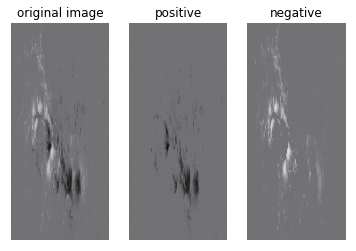

In [17]:
# the original image
image = data[0]

cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True) # use the grayscale color map
fig = plt.subplots(nrows=1, ncols=3)


for i, pair in enumerate([(image,'original image'),
                    (np.where(image>0,image,0),'positive'),
                   (np.where(image<0,image,0),'negative')]):
    ax = plt.subplot(1,3,i+1)
    sns.heatmap(pair[0],center=0, cmap=cmap,cbar=False,xticklabels=False, yticklabels=False, ax=ax)
    ax.title.set_text(pair[1])

And all positive pixels in the positive component image are ranked in __ascending order__. And in this rank, there is a parameter named `polar_threshold` in the instantiation of `PIL()`, ranges from 0 to 1, that specifies a percentage quantile in this ranked sequence, which is the threshold for determining whether a pixel is a "strong" positive pixel. If one sets `polar_threshold=0.90`, this means that the top 10% of all positive pixels are considerd as the "strong" positive pixels in this image. The same applies to the negative component.

#### Step 2: Image Maxpooling

After setting the `polar_threshold`, one has a threshold for defining a strong positive pixel and a strong negative pixel. To meet the __first criterion__ we specified at the beginning, we need to find all pixels in the original image that has a strong positive pixel and a strong negative pixel __nearby__. The optional parameter `window_size` in the `.fit()` method defines the range of this "nearbyness". The default value of `window_size` is 5, which means that for each pixel in the image, find a 5\*5 subimage that contains the pixel of interest at its center. This subimage is the "neighborhood" of pixel. For example, in the following grayscale image, the point marked with a star has its 20\*20 neighborhood defined by the green square box.

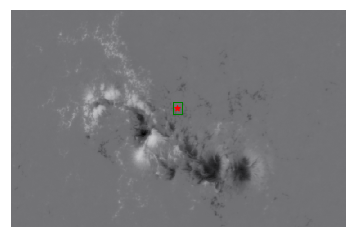

In [51]:
# A simple illustration of what it means as a neightborhood.
sns.heatmap(image,center=0, cmap=cmap,cbar=False,xticklabels=False, yticklabels=False)
plt.scatter(370,170,marker="*",c='red')
plt.plot([360, 360], [160, 180], 'k-', lw=1,c='green')
plt.plot([380, 380], [160, 180], 'k-', lw=1,c='green')
plt.plot([360, 380], [160, 160], 'k-', lw=1,c='green')
plt.plot([360, 380], [180,180], 'k-', lw=1,c='green')

And within this neighborhood,